In [1]:
%load_ext jupyter_black
import os
from glob import glob
import pandas as pd
import numpy as np
from wxlab import probsevere
from wxlab.forecast import Grib

/home/leaver2000/wxpy/wxlab/probsevere.py:65: UserWarning: registration of accessor <class 'wxlab.probsevere.GeoAccessor'> under name 'geo' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class GeoAccessor:


In [2]:
def sort_data(*args: str) -> list[str]:
    return sorted(glob(os.path.join("data", *args)))


def unpack_files(ALL_PROBSEVERE_FILES, ALL_GALWEM_FILES, time_buffer: int = 90) -> tuple[pd.Series, pd.Series]:
    # GALWEM FILES
    fcst = pd.Series(ALL_GALWEM_FILES, name="GALWEM")

    g_times: pd.DataFrame = fcst.str.extract(r"FH.(?P<forecast_hour>\d{3})_DF__(?P<valid_time>\d{8})")
    fcst.index = pd.to_datetime(g_times["valid_time"]) + pd.to_timedelta(
        g_times["forecast_hour"].astype(int), unit="h"
    )
    # PROBSEVERE_FILES
    ps = pd.Series(ALL_PROBSEVERE_FILES, name="ProbSevere")
    ps.index = pd.Index(pd.to_datetime(ps.str.replace("_", "T").str.extract(r"(\d*T\d*).json")[0]), name="validTime")

    buffer = pd.to_timedelta(time_buffer, unit="m")
    condition = (ps.index > fcst.index.min() - buffer) & (ps.index < fcst.index.max() + buffer)

    return ps[condition], fcst


ps_data, raw_grib_data = unpack_files(sort_data("probsevere", "*.json"), sort_data("galwem", "*.GR2"))
ps_data, raw_grib_data

(validTime
 2022-05-19 22:30:39    data/probsevere/MRMS_PROBSEVERE_20220519_22303...
 2022-05-19 22:32:40    data/probsevere/MRMS_PROBSEVERE_20220519_22324...
 2022-05-19 22:34:37    data/probsevere/MRMS_PROBSEVERE_20220519_22343...
 2022-05-19 22:36:40    data/probsevere/MRMS_PROBSEVERE_20220519_22364...
 2022-05-19 22:38:39    data/probsevere/MRMS_PROBSEVERE_20220519_22383...
                                              ...                        
 2022-05-20 07:20:38    data/probsevere/MRMS_PROBSEVERE_20220520_07203...
 2022-05-20 07:22:41    data/probsevere/MRMS_PROBSEVERE_20220520_07224...
 2022-05-20 07:24:35    data/probsevere/MRMS_PROBSEVERE_20220520_07243...
 2022-05-20 07:26:41    data/probsevere/MRMS_PROBSEVERE_20220520_07264...
 2022-05-20 07:28:35    data/probsevere/MRMS_PROBSEVERE_20220520_07283...
 Name: ProbSevere, Length: 270, dtype: object,
 2022-05-20 00:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
 2022-05-20 03:00:00    data/galwem/PS.557WW_SC.U_DI.C

In [18]:
glwm_data = pd.Series(glob(os.path.join("data/galwem/*GR2")), name="GALWEM")

g_times: pd.DataFrame = glwm_data.str.extract(r"FH.(?P<forecast_hour>\d{3})_DF__(?P<valid_time>\d{8})")
glwm_data.index = pd.to_datetime(g_times["valid_time"]) + pd.to_timedelta(
    g_times["forecast_hour"].astype(int), unit="h"
)
glwm_data

2022-05-20 03:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
2022-05-20 00:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
2022-05-20 06:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
Name: GALWEM, dtype: object

In [3]:
grib = Grib("data/GALWEM.parquet")
grib

In [4]:
# Initalizing the grib takes some time to read the grib file.
# for this reason the grid data is put into a generator function
ds = grib.to_dataset()
ds

<xarray.Dataset>
Dimensions:    (validTime: 3, lat: 141, lon: 281, hPa: 13)
Coordinates:
  * validTime  (validTime) int64 1653004800000000000 ... 1653026400000000000
  * lat        (lat) float64 20.0 20.25 20.5 20.75 ... 54.25 54.5 54.75 55.0
  * lon        (lon) float64 230.0 230.2 230.5 230.8 ... 299.2 299.5 299.8 300.0
  * hPa        (hPa) float64 3e+03 5e+03 7e+03 1e+04 ... 7e+04 8.5e+04 1e+05
Data variables:
    temp       (validTime, lat, lon, hPa) float32 218.1 207.8 ... 268.5 275.2
    u_wind     (validTime, lat, lon, hPa) float32 -9.2 -6.28 -4.34 ... 9.89 4.62
    v_wind     (validTime, lat, lon, hPa) float32 0.31 -1.43 2.13 ... -5.46 2.53

In [7]:
fcst = grib.to_dataframe()
fcst

hPa                                3000.0      5000.0      7000.0    \
elements                               temp        temp        temp   
validTime           lat  lon                                          
1653004800000000000 20.0 230.00  218.069992  207.849991  199.869995   
                         230.25  218.129990  207.739990  199.839996   
                         230.50  218.220001  207.629990  199.819992   
                         230.75  218.199997  207.529999  199.879990   
                         231.00  218.059998  207.440002  199.879990   
...                                     ...         ...         ...   
1653026400000000000 55.0 299.00  224.259995  221.699997  221.879990   
                         299.25  224.299988  221.720001  221.750000   
                         299.50  224.349991  221.720001  221.639999   
                         299.75  224.449997  221.709991  221.559998   
                         300.00  224.580002  221.669998  221.470001   

hPa                                10000.0     15000.0     20000.0   \
elements                               temp        temp        temp   
validTime           lat  lon                                          
1653004800000000000 20.0 230.00  202.089996  209.399994  217.589996   
                         230.25  202.019989  209.389999  217.440002   
                         230.50  201.959991  209.259995  217.289993   
                         230.75  201.899994  209.069992  217.139999   
                         231.00  201.869995  208.889999  217.259995   
...                                     ...         ...         ...   
1653026400000000000 55.0 299.00  221.019989  226.190002  226.529999   
                         299.25  221.099991  226.000000  226.589996   
                         299.50  221.139999  225.839996  226.549988   
                         299.75  221.220001  225.669998  226.549988   
                         300.00  221.319992  225.419998  226.669998   

hPa                                25000.0     30000.0     40000.0   \
elements                               temp        temp        temp   
validTime           lat  lon                                          
1653004800000000000 20.0 230.00  229.019989  239.429993  252.839996   
                         230.25  229.080002  239.479996  253.039993   
                         230.50  229.059998  239.519989  253.279999   
                         230.75  228.929993  239.619995  253.509995   
                         231.00  228.860001  239.669998  253.569992   
...                                     ...         ...         ...   
1653026400000000000 55.0 299.00  224.220001  223.690002  236.720001   
                         299.25  224.129990  223.940002  236.739990   
                         299.50  224.049988  224.139999  236.759995   
                         299.75  223.899994  224.159988  236.860001   
                         300.00  223.610001  224.159988  237.049988   

hPa                                50000.0   ...   10000.0    15000.0   \
elements                               temp  ...     v_wind     v_wind   
validTime           lat  lon                 ...                         
1653004800000000000 20.0 230.00  264.070007  ...  13.250000  19.359999   
                         230.25  264.149994  ...  13.090000  19.580000   
                         230.50  264.119995  ...  12.840000  20.020000   
                         230.75  264.089996  ...  12.599999  20.459999   
                         231.00  264.209991  ...  12.360000  20.740000   
...                                     ...  ...        ...        ...   
1653026400000000000 55.0 299.00  248.189987  ...   3.380000   4.000000   
                         299.25  248.139999  ...   3.500000   4.050000   
                         299.50  248.080002  ...   3.590000   4.130000   
                         299.75  248.110001  ...   3.640000   4.220000   
                         300.00  248.269989  ...   3.

In [ ]:
MRMS_ARCHIVE = "https://mrms.agron.iastate.edu/{year}/{month}/{day}/"
from datetime import datetime
import pandas as pd
pd.date_range()

In [8]:
fcst_validtime: pd.DatetimeIndex = fcst.index.unique("validTime").astype("datetime64[ns, utc]")
fcst_validtime

DatetimeIndex(['2022-05-20 00:00:00+00:00', '2022-05-20 03:00:00+00:00',
               '2022-05-20 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='validTime', freq=None)

In [9]:
def get_probsevere_files(ps_files: list[str], buffer: int | pd.Timedelta = 90):
    ps = pd.Series(ps_files, name="ProbSevere")
    vt = pd.to_datetime(ps.str.replace("_", "T").str.extract(r"(\d*T\d*).json")[0], utc=True)
    ps.index = pd.Index(vt, name="validTime")
    buffer = pd.to_timedelta(buffer, unit="m")
    condition = (ps.index > fcst_validtime.min() - buffer) & (ps.index < fcst_validtime.max() + buffer)
    return ps[condition]


ps_data = get_probsevere_files(sorted(glob(os.path.join("data", "probsevere", "*.json"))))
ps_data

validTime
2022-05-19 22:30:39+00:00    data/probsevere/MRMS_PROBSEVERE_20220519_22303...
2022-05-19 22:32:40+00:00    data/probsevere/MRMS_PROBSEVERE_20220519_22324...
2022-05-19 22:34:37+00:00    data/probsevere/MRMS_PROBSEVERE_20220519_22343...
2022-05-19 22:36:40+00:00    data/probsevere/MRMS_PROBSEVERE_20220519_22364...
2022-05-19 22:38:39+00:00    data/probsevere/MRMS_PROBSEVERE_20220519_22383...
                                                   ...                        
2022-05-20 07:20:38+00:00    data/probsevere/MRMS_PROBSEVERE_20220520_07203...
2022-05-20 07:22:41+00:00    data/probsevere/MRMS_PROBSEVERE_20220520_07224...
2022-05-20 07:24:35+00:00    data/probsevere/MRMS_PROBSEVERE_20220520_07243...
2022-05-20 07:26:41+00:00    data/probsevere/MRMS_PROBSEVERE_20220520_07264...
2022-05-20 07:28:35+00:00    data/probsevere/MRMS_PROBSEVERE_20220520_07283...
Name: ProbSevere, Length: 270, dtype: object

In [89]:
from datetime import datetime

from types import GeneratorType

from typing import NamedTuple, Type
from datetime import datetime
import pandas as pd
import pandas as pd
import xarray as xr

import geopandas as gpt
import pyarrow.parquet as pq
import pyarrow as pa
import geopandas as gpt
from shapely.geometry import MultiPolygon, Polygon, LinearRing


class Table:
    @staticmethod
    def from_pandas(pandas_object: pd.DataFrame | pd.Series):
        ...

    def to_pandas(self) -> pd.DataFrame | pd.Series:
        ...


def make_coordinates(exterior):
    return np.array([tuple(x.coords) for x in exterior], dtype=object)


class Probsevere:
    def __init__(self, data: str | pd.Series | dict[datetime, str]|pd.DataFrame):
        if isinstance(data, str):
            if data.endswith(".parquet"):
                df: pd.DataFrame = pq.read_table(data).to_pandas()
                if "coordinates" in df.columns:
                    df.insert(0, "geometry", [Polygon(map(tuple, x)) for x in df["coordinates"]])
                    df = gpt.GeoDataFrame(df.drop("coordinates", axis=1), geometry="geometry")
            
                self._data:df
                
                
            else:
                raise NotImplementedError
        elif isinstance(data,pd.DataFrame):
            self._data = data
        else:
            df = probsevere.to_dataframe(ps_data, datetime_dtype=np.int64)
            condition = df.columns[df.columns != "geometry"]
            df[condition] = df[condition].astype(np.float32)
            self._data = df

    def to_dataframe(self):
        return self._data.copy()

    def to_table(self):
        df = self.to_dataframe()
        df["coordinates"] = make_coordinates(df.geometry.exterior)
        df = df.drop("geometry", axis=1)
        return pa.Table.from_pandas(df)

    def to_parquet(self, filepath: str):
        table = self.to_table()
        return pq.write_table(table, filepath)

    def to_xarray(self):
        return self.to_dataframe().to_xarray()


ps = Probsevere("data/PROBSEVERE.parquet")
ps

In [90]:
ps.to_dataframe().to_xarray()

<xarray.Dataset>
Dimensions:            (validTime: 270, ID: 4008)
Coordinates:
  * validTime          (validTime) int64 1652999439000000000 ... 165303171500...
  * ID                 (ID) object '25310' '25384' '25496' ... '30549' '30550'
Data variables: (12/25)
    geometry           (validTime, ID) object POLYGON ((-90.2 38.8, -90.19 38...
    MUCAPE             (validTime, ID) float32 4.587e+03 3.571e+03 ... 2.923e+03
    MLCAPE             (validTime, ID) float32 2.95e+03 3.49e+03 ... 2.308e+03
    MLCIN              (validTime, ID) float32 -13.0 -24.0 0.0 ... -999.0 -999.0
    EBSHEAR            (validTime, ID) float32 38.6 42.8 48.0 ... 30.8 31.6 24.6
    SRH01KM            (validTime, ID) float32 86.0 194.0 428.0 ... 27.0 6.0
    ...                 ...
    LJA                (validTime, ID) float32 1.1 0.8 0.6 1.0 ... 0.0 0.0 0.0
    SIZE               (validTime, ID) float32 842.0 270.0 226.0 ... 62.0 136.0
    AVG_BEAM_HGT       (validTime, ID) float32 3.278 3.242 3.281 ... 3.279 3.278
    MOTION_EAST        (validTime, ID) float32 9.566 3.77 16.89 ... 10.48 10.48
    MOTION_SOUTH       (validTime, ID) float32 -9.504 -1.666 ... 10.21 10.21
    PS                 (validTime, ID) float32 75.0 48.0 28.0 ... 2.0 3.0 4.0

In [91]:
ps.to_table()

pyarrow.Table
MUCAPE: float
MLCAPE: float
MLCIN: float
EBSHEAR: float
SRH01KM: float
MEANWIND_1-3kmAGL: float
MESH: float
VIL_DENSITY: float
FLASH_RATE: float
FLASH_DENSITY: float
MAXLLAZ: float
P98LLAZ: float
P98MLAZ: float
MAXRC_EMISS: float
MAXRC_ICECF: float
WETBULB_0C_HGT: float
PWAT: float
CAPE_M10M30: float
LJA: float
SIZE: float
AVG_BEAM_HGT: float
MOTION_EAST: float
MOTION_SOUTH: float
PS: float
coordinates: list<item: list<item: double>>
  child 0, item: list<item: double>
      child 0, item: double
validTime: int64
ID: string
----
MUCAPE: [[4587,3571,182,2791,2954,...,3506,3080,3530,3497,2923]]
MLCAPE: [[2950,3490,10,1740,2227,...,1202,2349,2699,2694,2308]]
MLCIN: [[-13,-24,0,-85,-51,...,-110,-1,-999,-999,-999]]
EBSHEAR: [[38.6,42.8,48,39.1,40,...,25.1,25.2,30.8,31.6,24.6]]
SRH01KM: [[86,194,428,110,172,...,63,25,34,27,6]]
MEANWIND_1-3kmAGL: [[32.1,19.5,43.3,18.6,17.2,...,9.7,7.7,7.9,8.3,13.5]]
MESH: [[0.52,0.48,0.66,1.09,1.65,...,0.4,0.13,0,0,0.08]]
VIL_DENSITY: [[1.58,1.5

In [63]:
Probsevere("data/PROBSEVERE.parquet").to_dataframe()

geometry  \
validTime           ID                                                         
1652999439000000000 25310  POLYGON ((-90.20000 38.80000, -90.19000 38.790...   
                    25384  POLYGON ((-85.62000 38.08000, -85.60000 38.080...   
                    25496  POLYGON ((-90.50000 45.10000, -90.43000 45.100...   
                    25504  POLYGON ((-86.52000 39.12000, -86.47000 39.110...   
                    25505  POLYGON ((-87.12000 38.79000, -87.06000 38.790...   
...                                                                      ...   
1653031715000000000 30546  POLYGON ((-77.31000 31.34000, -77.28000 31.340...   
                    30547  POLYGON ((-80.15000 26.69000, -80.09000 26.690...   
                    30548  POLYGON ((-79.21000 26.36000, -79.18000 26.360...   
                    30549  POLYGON ((-79.08000 26.29000, -79.04000 26.290...   
                    30550  POLYGON ((-81.92000 26.11000, -81.87000 26.110...   

                          MUCAPE MLCAPE MLCIN EBSHEAR SRH01KM  \
validTime           ID                                          
1652999439000000000 25310   4587   2950   -13    38.6      86   
                    25384   3571   3490   -24    42.8     194   
                    25496    182     10     0    48.0     428   
                    25504   2791   1740   -85    39.1     110   
                    25505   2954   2227   -51    40.0     172   
...                          ...    ...   ...     ...     ...   
1653031715000000000 30546   3506   1202  -110    25.1      63   
                    30547   3080   2349    -1    25.2      25   
                    30548   3530   2699  -999    30.8      34   
                    30549   3497   2694  -999    31.6      27   
                    30550   2923   2308  -999    24.6       6   

                          MEANWIND_1-3kmAGL  MESH VIL_DENSITY FLASH_RATE  ...  \
validTime           ID                                                    ...   
1652999439000000000 25310              32.1  0.52        1.58         71  ...   
                    25384              19.5  0.48        1.57         28  ...   
                    25496              43.3  0.66        2.24         13  ...   
                    25504              18.6  1.09        2.64         35  ...   
                    25505              17.2  1.65        2.91         39  ...   
...                                     ...   ...         ...        ...  ...   
1653031715000000000 30546               9.7  0.40        0.51          0  ...   
                    30547               7.7  0.13        0.75          0  ...   
                    30548               7.9  0.00        0.66          0  ...   
                    30549               8.3  0.00        0.40          0  ...   
                    30550              13.5  0.08        0.88          0  ...   

                          MAXRC_ICECF WETBULB_0C_HGT PWAT CAPE_M10M30  LJA  \
validTime           ID                                                       
1652999439000000000 25310         0.0           11.9  2.0         816  1.1   
                    25384         0.0           11.5  1.8         859  0.8   
                    25496         1.0            9.3  1.3          14  0.6   
                    25504         0.0           10.4  1.7         652  1.0   
                    25505         0.0           11.5  1.7         843  2.0   
...                               ...            ...  ...         ...  ...   
1653031715000000000 30546         0.0           12.4  1.2         815  0.0   
                    30547         0.0           12.4  2.0         683  0.0   
                    30548         0.0           12.4  1.8         705  0.0   
                    30549         0.0           12.4  1.8         691  0.0   
                    30550         2.0           12.6  2.0         635  0.0   

                           SIZE AVG_BEAM_HGT MOTION_EAST MOTION_SOUTH  PS  
validTime           ID              

In [49]:
import geopandas as gpt
from shapely.geometry import MultiPolygon, Polygon, LinearRing

df = ps.to_dataframe().copy()
df["x"] = np.array([tuple(x.coords) for x in df.geometry.exterior], dtype=object)
df = df.drop("geometry", axis=1)
table = pa.Table.from_pandas(df)
# table.x
df2 = table.to_pandas()
df2["geometry"] = [Polygon(map(tuple, x)) for x in df2.x]
gpt.GeoDataFrame(df2.drop("x", axis=1), geometry="geometry")




# [for x in df2.x.iloc[0]]
# df2.x.apply(list)
# df.x, df2.x
# table
# list(map(Polygon, df2.x))
# Polygon(df.x.iloc[0])
# df2.x.values[0].T
# Polygon(df2.x.values[0])
# df2.x.iloc[0]  # .values[0]
# gpt.GeoSeries(df2.x.explode())
# tuple(df2.x.values[0].T)  # .tolist()
# # MultiPolygon(np.dstack(df2.geometry.values))
# def remake():
#     for s in df2.x.values:
#         print(s)
#         # for x in s:
#         #     print(x)
#             # yield Polygon(x)


# remake()
# list(remake())
# [[x for x in df2.x.values.tolist()]]
# [Polygon(x) for x in df2.x]
# MultiPolygon(df2.geometry)

# GeoDataFrame(df2, geometry=df2.geometry)

# ps.to_dataframe()
# hash(ps.to_dataset().geometry.values[0])
# dict(zip(ps.to_dataset().geometry.values, ps.to_dataset().geometry.values))  # .set_index("geometry", append=True))

MUCAPE MLCAPE MLCIN EBSHEAR SRH01KM  \
validTime           ID                                          
1652999439000000000 25310   4587   2950   -13    38.6      86   
                    25384   3571   3490   -24    42.8     194   
                    25496    182     10     0    48.0     428   
                    25504   2791   1740   -85    39.1     110   
                    25505   2954   2227   -51    40.0     172   
...                          ...    ...   ...     ...     ...   
1653031715000000000 30546   3506   1202  -110    25.1      63   
                    30547   3080   2349    -1    25.2      25   
                    30548   3530   2699  -999    30.8      34   
                    30549   3497   2694  -999    31.6      27   
                    30550   2923   2308  -999    24.6       6   

                          MEANWIND_1-3kmAGL  MESH VIL_DENSITY FLASH_RATE  \
validTime           ID                                                     
1652999439000000000 25310              32.1  0.52        1.58         71   
                    25384              19.5  0.48        1.57         28   
                    25496              43.3  0.66        2.24         13   
                    25504              18.6  1.09        2.64         35   
                    25505              17.2  1.65        2.91         39   
...                                     ...   ...         ...        ...   
1653031715000000000 30546               9.7  0.40        0.51          0   
                    30547               7.7  0.13        0.75          0   
                    30548               7.9  0.00        0.66          0   
                    30549               8.3  0.00        0.40          0   
                    30550              13.5  0.08        0.88          0   

                          FLASH_DENSITY  ... WETBULB_0C_HGT PWAT CAPE_M10M30  \
validTime           ID                   ...                                   
1652999439000000000 25310          0.76  ...           11.9  2.0         816   
                    25384          0.66  ...           11.5  1.8         859   
                    25496          0.46  ...            9.3  1.3          14   
                    25504          0.84  ...           10.4  1.7         652   
                    25505          0.92  ...           11.5  1.7         843   
...                                 ...  ...            ...  ...         ...   
1653031715000000000 30546          0.00  ...           12.4  1.2         815   
                    30547          0.00  ...           12.4  2.0         683   
                    30548          0.03  ...           12.4  1.8         705   
                    30549          0.00  ...           12.4  1.8         691   
                    30550          0.03  ...           12.6  2.0         635   

                           LJA  SIZE AVG_BEAM_HGT MOTION_EAST MOTION_SOUTH  \
validTime           ID                                                       
1652999439000000000 25310  1.1   842     3.277778       9.566       -9.504   
                    25384  0.8   270     3.242424        3.77       -1.666   
                    25496  0.6   226     3.280851      16.893       -3.447   
                    25504  1.0   328     3.293478      13.776        0.591   
                    25505  2.0   241     3.270000      13.621        -1.49   
...                        ...   ...          ...         ...          ...   
1653031715000000000 30546  0.0    72     3.278947      10.478       10.213   
                    30547  0.0    48     3.268750       4.937       -4.723   
                    30548  0.0    45     3.283898      10.459       10.169   
                    30549  0.0    62     3.279070      10.478       10.213   
                    30550  0.0   136     3.277778      10.478       10.213   

                           PS  \
validTime           ID          
1652999439000000000 25310  75   
                    25384  48   
   

geometry  \
validTime           ID                                                         
1652999439000000000 25310  POLYGON ((-90.20000 38.80000, -90.19000 38.790...   
                    25384  POLYGON ((-85.62000 38.08000, -85.60000 38.080...   
                    25496  POLYGON ((-90.50000 45.10000, -90.43000 45.100...   
                    25504  POLYGON ((-86.52000 39.12000, -86.47000 39.110...   
                    25505  POLYGON ((-87.12000 38.79000, -87.06000 38.790...   
...                                                                      ...   
1653031715000000000 30546  POLYGON ((-77.31000 31.34000, -77.28000 31.340...   
                    30547  POLYGON ((-80.15000 26.69000, -80.09000 26.690...   
                    30548  POLYGON ((-79.21000 26.36000, -79.18000 26.360...   
                    30549  POLYGON ((-79.08000 26.29000, -79.04000 26.290...   
                    30550  POLYGON ((-81.92000 26.11000, -81.87000 26.110...   

                          MUCAPE MLCAPE MLCIN EBSHEAR SRH01KM  \
validTime           ID                                          
1652999439000000000 25310   4587   2950   -13    38.6      86   
                    25384   3571   3490   -24    42.8     194   
                    25496    182     10     0    48.0     428   
                    25504   2791   1740   -85    39.1     110   
                    25505   2954   2227   -51    40.0     172   
...                          ...    ...   ...     ...     ...   
1653031715000000000 30546   3506   1202  -110    25.1      63   
                    30547   3080   2349    -1    25.2      25   
                    30548   3530   2699  -999    30.8      34   
                    30549   3497   2694  -999    31.6      27   
                    30550   2923   2308  -999    24.6       6   

                          MEANWIND_1-3kmAGL  MESH VIL_DENSITY FLASH_RATE  ...  \
validTime           ID                                                    ...   
1652999439000000000 25310              32.1  0.52        1.58         71  ...   
                    25384              19.5  0.48        1.57         28  ...   
                    25496              43.3  0.66        2.24         13  ...   
                    25504              18.6  1.09        2.64         35  ...   
                    25505              17.2  1.65        2.91         39  ...   
...                                     ...   ...         ...        ...  ...   
1653031715000000000 30546               9.7  0.40        0.51          0  ...   
                    30547               7.7  0.13        0.75          0  ...   
                    30548               7.9  0.00        0.66          0  ...   
                    30549               8.3  0.00        0.40          0  ...   
                    30550              13.5  0.08        0.88          0  ...   

                          MAXRC_ICECF WETBULB_0C_HGT PWAT CAPE_M10M30  LJA  \
validTime           ID                                                       
1652999439000000000 25310         0.0           11.9  2.0         816  1.1   
                    25384         0.0           11.5  1.8         859  0.8   
                    25496         1.0            9.3  1.3          14  0.6   
                    25504         0.0           10.4  1.7         652  1.0   
                    25505         0.0           11.5  1.7         843  2.0   
...                               ...            ...  ...         ...  ...   
1653031715000000000 30546         0.0           12.4  1.2         815  0.0   
                    30547         0.0           12.4  2.0         683  0.0   
                    30548         0.0           12.4  1.8         705  0.0   
                    30549         0.0           12.4  1.8         691  0.0   
                    30550         2.0           12.6  2.0         635  0.0   

                           SIZE AVG_BEAM_HGT MOTION_EAST MOTION_SOUTH  PS  
validTime           ID              

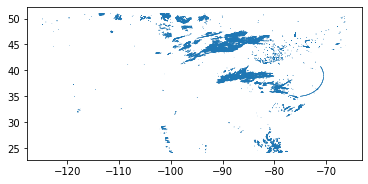

In [78]:
ps = probsevere.to_dataframe(ps_data, datetime_dtype=np.int64)  # .astype(np.float32)
ps.plot()
ps

In [11]:
# PROBSEVERE DATA IS AVALIABLE AT A 2 MIN INTERVAL
# THE VALIDTIME IS SET TO THE NEAREST VALIDTIME IN FORECAST MODEL
p1 = probsevere.align_time(ps, fcst).droplevel(0)  # .swaplevel(0, -1)

assert p1.index.get_level_values("validTime").isin(fcst.index.get_level_values("validTime")).all()
assert all(p1.index.unique("validTime") == fcst.index.unique("validTime"))
p1  # TIMES ARE FIT!

,geometry,MUCAPE,MLCAPE,MLCIN,EBSHEAR,SRH01KM,MEANWIND_1-3kmAGL,MESH,VIL_DENSITY,FLASH_RATE,...,MAXRC_ICECF,WETBULB_0C_HGT,PWAT,CAPE_M10M30,LJA,SIZE,AVG_BEAM_HGT,MOTION_EAST,MOTION_SOUTH,PS
validTime,,,,,,,,,,,,,,,,,,,,,
1653004800000000000,"POLYGON ((-90.20000 38.80000, -90.19000 38.790...",4587,2950,-13,38.6,86,32.1,0.52,1.58,71,...,0.0,11.9,2.0,816,1.1,842,3.277778,9.566,-9.504,75
1653004800000000000,"POLYGON ((-85.62000 38.08000, -85.60000 38.080...",3571,3490,-24,42.8,194,19.5,0.48,1.57,28,...,0.0,11.5,1.8,859,0.8,270,3.242424,3.77,-1.666,48
1653004800000000000,"POLYGON ((-90.50000 45.10000, -90.43000 45.100...",182,10,0,48.0,428,43.3,0.66,2.24,13,...,1.0,9.3,1.3,14,0.6,226,3.280851,16.893,-3.447,28
1653004800000000000,"POLYGON ((-86.52000 39.12000, -86.47000 39.110...",2791,1740,-85,39.1,110,18.6,1.09,2.64,35,...,0.0,10.4,1.7,652,1.0,328,3.293478,13.776,0.591,89
1653004800000000000,"POLYGON ((-87.12000 38.79000, -87.06000 38.790...",2954,2227,-51,40.0,172,17.2,1.65,2.91,39,...,0.0,11.5,1.7,843,2.0,241,3.270000,13.621,-1.49,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653026400000000000,"POLYGON ((-77.31000 31.34000, -77.28000 31.340...",3506,1202,-110,25.1,63,9.7,0.40,0.51,0,...,0.0,12.4,1.2,815,0.0,72,3.278947,10.478,10.213,5
1653026400000000000,"POLYGON ((-80.15000 26.69000, -80.09000 26.690...",3080,2349,-1,25.2,25,7.7,0.13,0.75,0,...,0.0,12.4,2.0,683,0.0,48,3.268750,4.937,-4.723,2
1653026400000000000,"POLYGON ((-79.21000 26.36000, -79.18000 26.360...",3530,2699,-999,30.8,34,7.9,0.00,0.66,0,...,0.0,12.4,1.8,705,0.0,45,3.283898,10.459,10.169,2


In [12]:
# long1 = -180~180 , long3 = 0~360
# GRIB.CRDS = long3, PROBSEVRE.CRDS = long1
# THE N-S-E-W BOUNDS FOR THE PS POLYGON ARE SET TO THE NEAREST GRID CRD
p2 = probsevere.reshape_geometry(p1, fcst).astype(np.float32)
p2

MUCAPE  MLCAPE  MLCIN  \
validTime           WEST   EAST   NORTH SOUTH                          
1653004800000000000 269.75 270.00 38.75 38.25  4587.0  2950.0  -13.0   
                    274.25 274.50 38.00 38.00  3571.0  3490.0  -24.0   
                    269.50 269.50 45.00 45.00   182.0    10.0    0.0   
                    273.25 273.50 39.00 39.00  2791.0  1740.0  -85.0   
                    272.75 273.00 38.75 38.75  2954.0  2227.0  -51.0   
...                                               ...     ...    ...   
1653026400000000000 282.75 282.75 31.25 31.25  3506.0  1202.0 -110.0   
                    279.75 280.00 26.75 26.50  3080.0  2349.0   -1.0   
                    280.75 280.75 26.25 26.25  3530.0  2699.0 -999.0   
                    281.00 281.00 26.25 26.25  3497.0  2694.0 -999.0   
                    278.00 278.25 26.00 26.00  2923.0  2308.0 -999.0   

                                                 EBSHEAR  SRH01KM  \
validTime           WEST   EAST   NORTH SOUTH                       
1653004800000000000 269.75 270.00 38.75 38.25  38.599998     86.0   
                    274.25 274.50 38.00 38.00  42.799999    194.0   
                    269.50 269.50 45.00 45.00  48.000000    428.0   
                    273.25 273.50 39.00 39.00  39.099998    110.0   
                    272.75 273.00 38.75 38.75  40.000000    172.0   
...                                                  ...      ...   
1653026400000000000 282.75 282.75 31.25 31.25  25.100000     63.0   
                    279.75 280.00 26.75 26.50  25.200001     25.0   
                    280.75 280.75 26.25 26.25  30.799999     34.0   
                    281.00 281.00 26.25 26.25  31.600000     27.0   
                    278.00 278.25 26.00 26.00  24.600000      6.0   

                                               MEANWIND_1-3kmAGL  MESH  \
validTime           WEST   EAST   NORTH SOUTH                            
1653004800000000000 269.75 270.00 38.75 38.25          32.099998  0.52   
                    274.25 274.50 38.00 38.00          19.500000  0.48   
                    269.50 269.50 45.00 45.00          43.299999  0.66   
                    273.25 273.50 39.00 39.00          18.600000  1.09   
                    272.75 273.00 38.75 38.75          17.200001  1.65   
...                                                          ...   ...   
1653026400000000000 282.75 282.75 31.25 31.25           9.700000  0.40   
                    279.75 280.00 26.75 26.50           7.700000  0.13   
                    280.75 280.75 26.25 26.25           7.900000  0.00   
                    281.00 281.00 26.25 26.25           8.300000  0.00   
                    278.00 278.25 26.00 26.00          13.500000  0.08   

                                               VIL_DENSITY  FLASH_RATE  \
validTime           WEST   EAST   NORTH SOUTH                            
1653004800000000000 269.75 270.00 38.75 38.25         1.58        71.0   
                    274.25 274.50 38.00 38.00         1.57        28.0   
                    269.50 269.50 45.00 45.00         2.24        13.0   
                    273.25 273.50 39.00 39.00         2.64        35.0   
                    272.75 273.00 38.75 38.75         2.91        39.0   
...                                                    ...         ...   
1653026400000000000 282.75 282.75 31.25 31.25         0.51         0.0   
                    279.75 280.00 26.75 26.50         0.75         0.0   
                    280.75 280.75 26.25 26.25         0.66         0.0   
                    281.00 281.00 26.25 26.25         0.40         0.0   
                    278.00 278.25 26.00 26.00         0.88         0.0   

                                               FLASH_DENSITY  ...  \
validTime           WEST   EAST   NORTH SOUTH                 ...   
1653004800000000000 269.75 270.00 38.75 38.25           0.76  ...   
                    274.25 274.50 38.00 38.00           0.66  ...   
          

In [13]:
# FINAL STEP OF ALINGMENT
p3 = probsevere.meshgrid(p2)
assert p3.index.isin(fcst.index).all()
#
df = pd.DataFrame(np.zeros((len(fcst.index), len(p3.columns)), dtype=np.float32), index=fcst.index, columns=p3.columns)

df.loc[p3.index] = p3
assert all(df.index == fcst.index) & all(df.columns == p2.columns) & all(df.columns == p3.columns)
df

# np.zeros(())
# df = df.fillna(0).reset_index(["lat", "lon"])
# assert all(df.index == fcst.index)
# df

MUCAPE  MLCAPE  MLCIN  EBSHEAR  SRH01KM  \
validTime           lat  lon                                               
1653004800000000000 20.0 230.00     0.0     0.0    0.0      0.0      0.0   
                         230.25     0.0     0.0    0.0      0.0      0.0   
                         230.50     0.0     0.0    0.0      0.0      0.0   
                         230.75     0.0     0.0    0.0      0.0      0.0   
                         231.00     0.0     0.0    0.0      0.0      0.0   
...                                 ...     ...    ...      ...      ...   
1653026400000000000 55.0 299.00     0.0     0.0    0.0      0.0      0.0   
                         299.25     0.0     0.0    0.0      0.0      0.0   
                         299.50     0.0     0.0    0.0      0.0      0.0   
                         299.75     0.0     0.0    0.0      0.0      0.0   
                         300.00     0.0     0.0    0.0      0.0      0.0   

                                 MEANWIND_1-3kmAGL  MESH  VIL_DENSITY  \
validTime           lat  lon                                            
1653004800000000000 20.0 230.00                0.0   0.0          0.0   
                         230.25                0.0   0.0          0.0   
                         230.50                0.0   0.0          0.0   
                         230.75                0.0   0.0          0.0   
                         231.00                0.0   0.0          0.0   
...                                            ...   ...          ...   
1653026400000000000 55.0 299.00                0.0   0.0          0.0   
                         299.25                0.0   0.0          0.0   
                         299.50                0.0   0.0          0.0   
                         299.75                0.0   0.0          0.0   
                         300.00                0.0   0.0          0.0   

                                 FLASH_RATE  FLASH_DENSITY  ...  MAXRC_ICECF  \
validTime           lat  lon                                ...                
1653004800000000000 20.0 230.00         0.0            0.0  ...          0.0   
                         230.25         0.0            0.0  ...          0.0   
                         230.50         0.0            0.0  ...          0.0   
                         230.75         0.0            0.0  ...          0.0   
                         231.00         0.0            0.0  ...          0.0   
...                                     ...            ...  ...          ...   
1653026400000000000 55.0 299.00         0.0            0.0  ...          0.0   
                         299.25         0.0            0.0  ...          0.0   
                         299.50         0.0            0.0  ...          0.0   
                         299.75         0.0            0.0  ...          0.0   
                         300.00         0.0            0.0  ...          0.0   

                                 WETBULB_0C_HGT  PWAT  CAPE_M10M30  LJA  SIZE  \
validTime           lat  lon                                                    
1653004800000000000 20.0 230.00             0.0   0.0          0.0  0.0   0.0   
                         230.25             0.0   0.0          0.0  0.0   0.0   
                         230.50             0.0   0.0          0.0  0.0   0.0   
                         230.75             0.0   0.0          0.0  0.0   0.0   
                         231.00             0.0   0.0          0.0  0.0   0.0   
...                                         ...   ...          ...  ...   ...   
1653026400000000000 55.0 299.00             0.0   0.0          0.0  0.0   0.0   
                         299.25             0.0   0.0          0.0  0.0   0.0   
                         299.50             0.0   0.0          0.0  0.0   0.0   
                         299.75             0.0   0.0          0.0  0.0   0.0   
                         300.00             0.0   0.0          0.0  0.0   0.0   


In [14]:
import cartopy.crs as ccrs

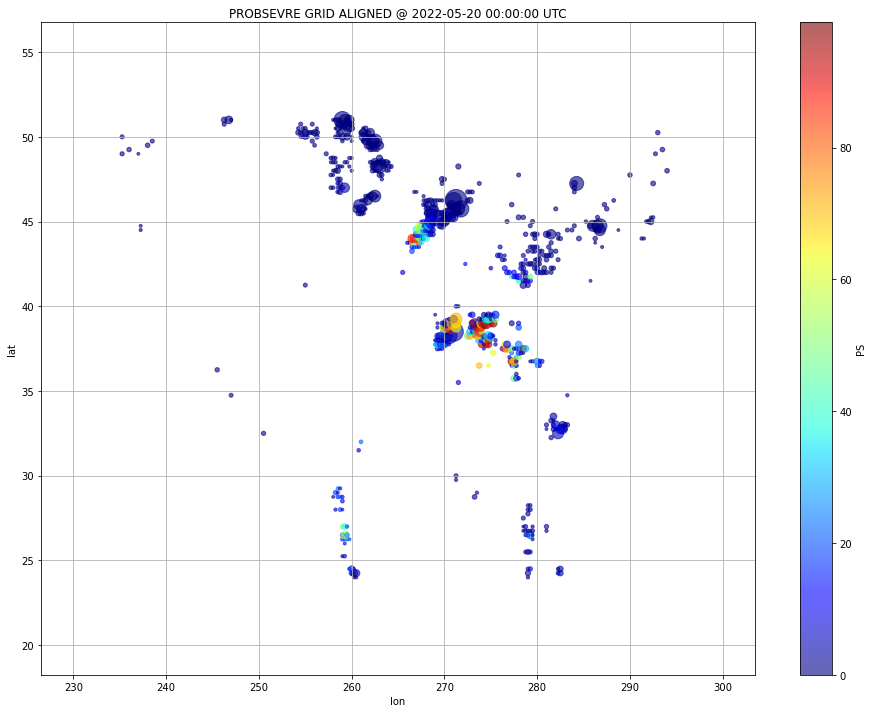

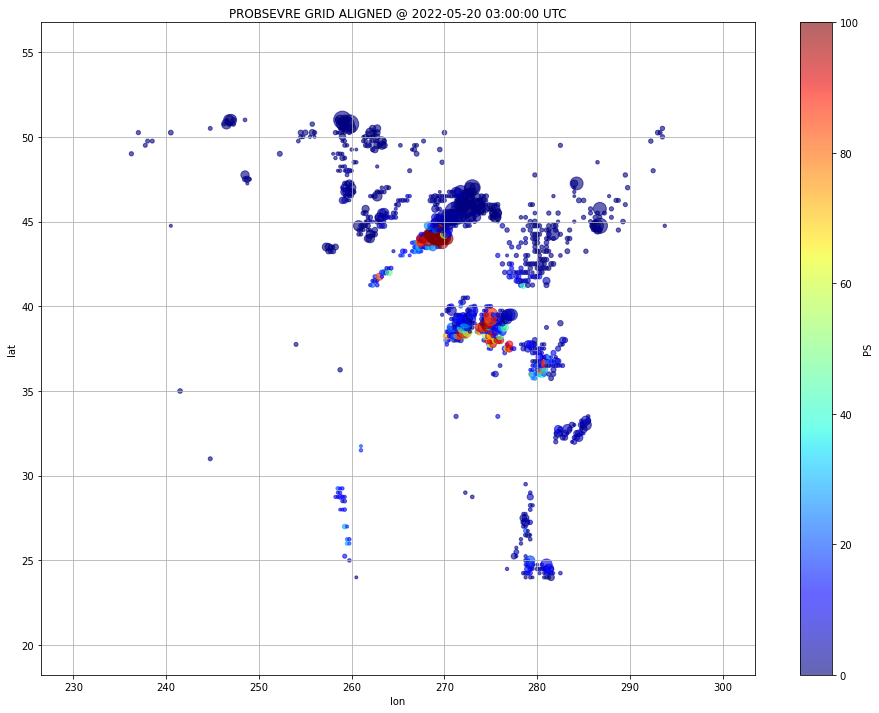

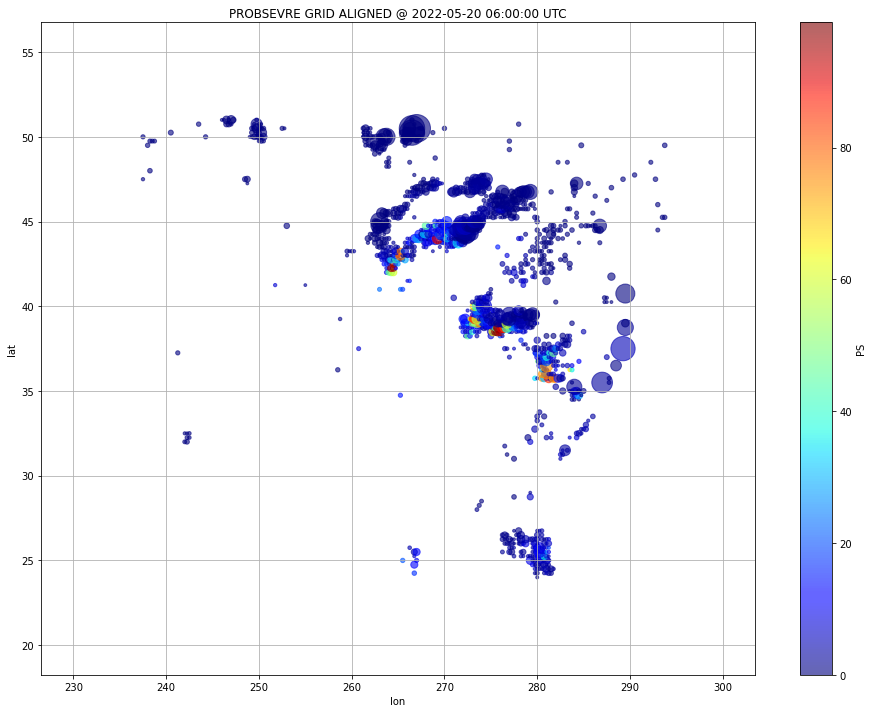

In [15]:
import matplotlib.pyplot as plt

# import cartopy

plt.rcParams["axes.grid"] = True
df2 = df.reset_index(["lat", "lon"])
df2.SIZE = df2.SIZE * 0.2


for vt in df.index.unique("validTime"):
    fig, ax = plt.subplots()
    plt.title(f"PROBSEVRE GRID ALIGNED @ {pd.to_datetime(vt)} UTC")
    df2.loc[vt].plot(
        kind="scatter",
        c="PS",
        s="SIZE",  # df2.SIZE.values[:, np.newaxis].T,
        x="lon",
        ax=ax,
        y="lat",
        figsize=(16, 12),
        cmap=plt.get_cmap("jet"),
        alpha=0.6,
    )
# df2.SIZE.values.max()